# Crop Disease Classification Notebook

## Part 1: Data Exploration

This notebook follows the take-home task requirements:

1. Load and visualize sample images from 5+ disease classes (subset of 10–15 total classes).

2. Show class distribution.

3. Train transfer learning model (MobileNetV3 Small / EfficientNet B0 optional).

4. Evaluate with confusion matrix and sample predictions.

5. Provide business recommendation.

6. (Optional) Prepare Gradio app artifacts.



Adjust `DATA_ROOT` below to point to your PlantVillage dataset root.


Found 16 class directories.
Selected classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite']
Train/Val/Test sizes: 10545, 2109, 1406
Train/Val/Test sizes: 10545, 2109, 1406


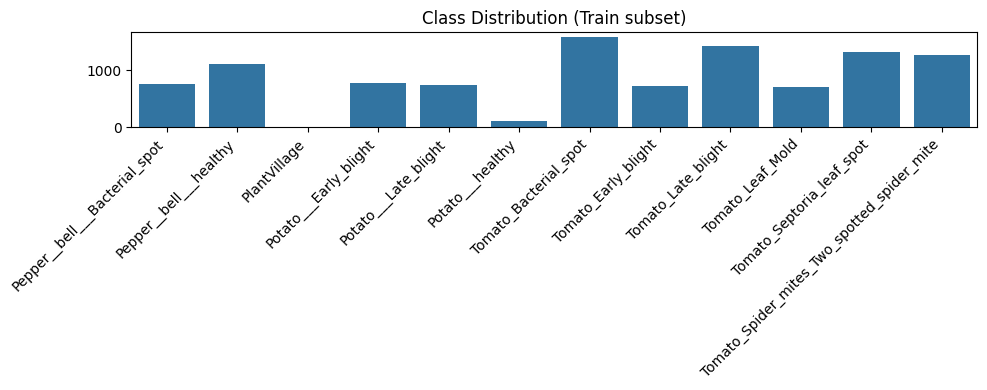

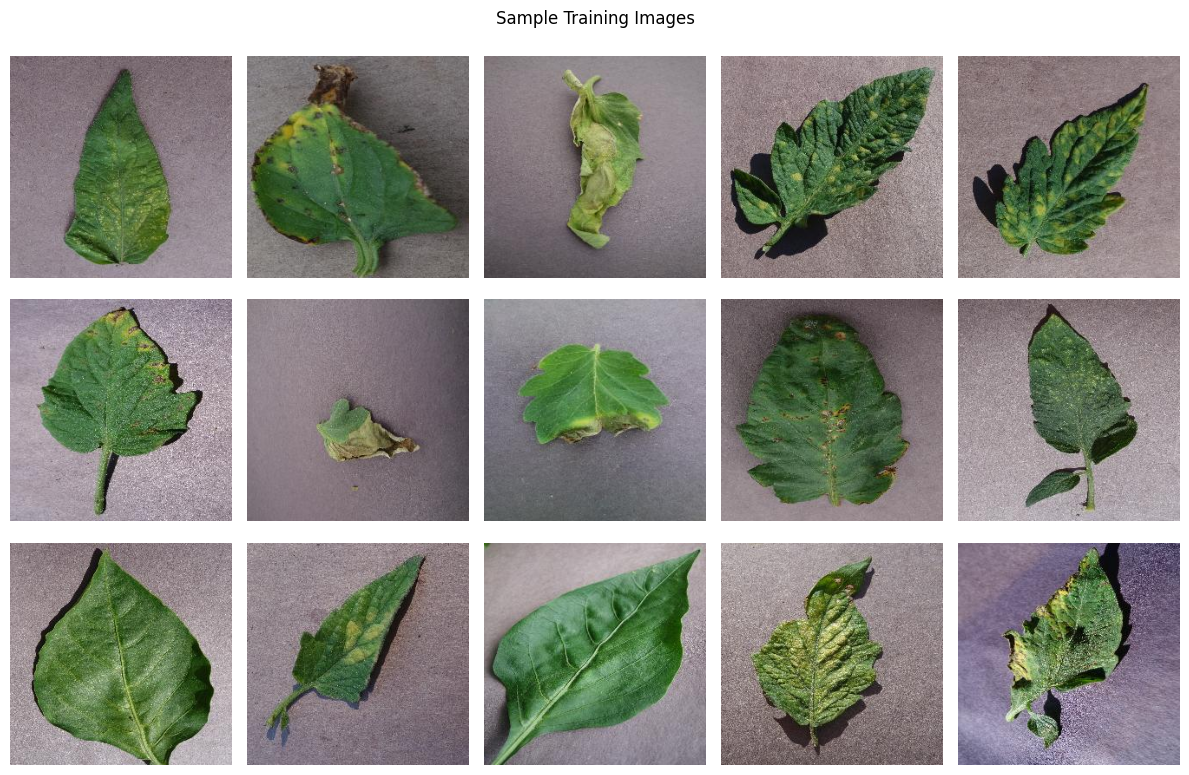

c:\Users\Rishi\Rishi's coding projects\crop disease identification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rishi\Rishi's coding projects\crop disease identification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: train_acc=0.832 val_acc=0.933
Epoch 2: train_acc=0.918 val_acc=0.955
Epoch 2: train_acc=0.918 val_acc=0.955
Epoch 3: train_acc=0.939 val_acc=0.971
Epoch 3: train_acc=0.939 val_acc=0.971
Epoch 4: train_acc=0.948 val_acc=0.980
Epoch 4: train_acc=0.948 val_acc=0.980
Epoch 5: train_acc=0.946 val_acc=0.967
Epoch 5: train_acc=0.946 val_acc=0.967
Epoch 6: train_acc=0.948 val_acc=0.953
Epoch 6: train_acc=0.948 val_acc=0.953
Epoch 7: train_acc=0.950 val_acc=0.972
Epoch 7: train_acc=0.950 val_acc=0.972
Epoch 8: train_acc=0.954 val_acc=0.963
Epoch 8: train_acc=0.954 val_acc=0.963
Epoch 9: train_acc=0.958 val_acc=0.973
Epoch 9: train_acc=0.958 val_acc=0.973
Epoch 10: train_acc=0.957 val_acc=0.963
Epoch 10: train_acc=0.957 val_acc=0.963


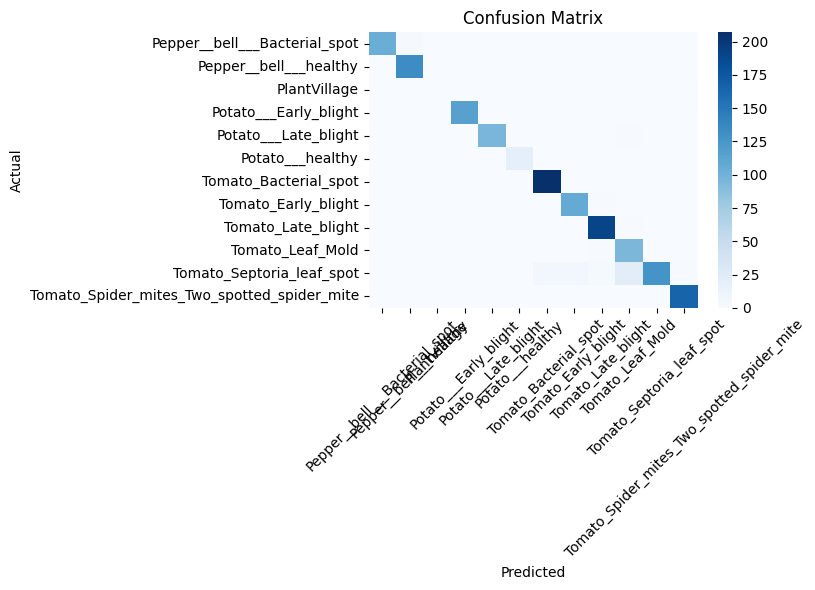

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.97      0.99       107
                     Pepper__bell___healthy       0.98      1.00      0.99       133
                               PlantVillage       0.00      0.00      0.00         0
                      Potato___Early_blight       1.00      1.00      1.00       115
                       Potato___Late_blight       1.00      0.99      0.99        97
                           Potato___healthy       1.00      1.00      1.00        19
                      Tomato_Bacterial_spot       0.97      1.00      0.98       207
                        Tomato_Early_blight       0.95      0.99      0.97       108
                         Tomato_Late_blight       0.97      0.99      0.98       192
                           Tomato_Leaf_Mold       0.80      0.99      0.88        96
                  Tomato_Septoria_leaf_spot       1.00      0.76

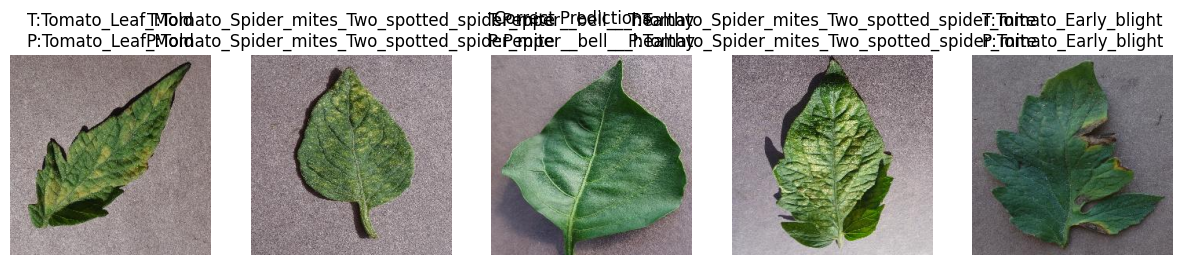

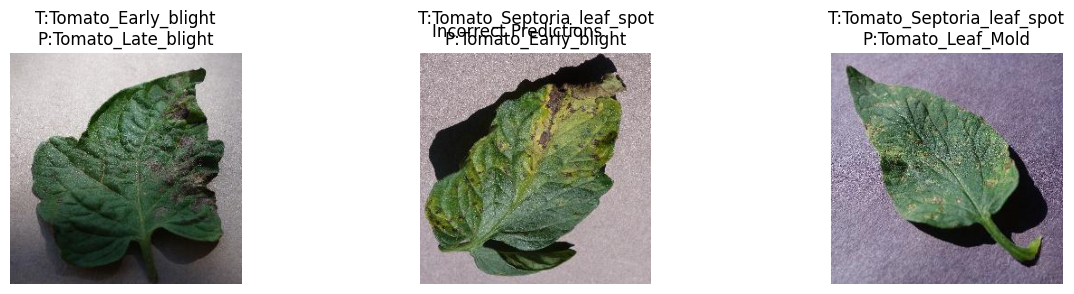

Notebook processing complete.


In [1]:
import os, random, json, itertools, math, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report

# Configuration
DATA_ROOT = Path("data/raw/PlantVillage")  # Change to your dataset root 
OUTPUT_DIR = Path("outputs"); OUTPUT_DIR.mkdir(exist_ok=True)
MODEL_DIR = Path("models"); MODEL_DIR.mkdir(exist_ok=True)
RANDOM_SEED = 42
NUM_CLASSES_TARGET = 12  # choose between 10-15
BATCH_SIZE = 32
NUM_EPOCHS = 10
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Expect folder layout: DATA_ROOT/<class_name>/*.jpg
all_class_dirs = [d for d in DATA_ROOT.iterdir() if d.is_dir()] if DATA_ROOT.exists() else []
if not all_class_dirs:
    print(f"WARNING: DATA_ROOT '{DATA_ROOT}' not found or empty. Populate it before running training.")
else:
    print(f"Found {len(all_class_dirs)} class directories.")

# Select subset deterministically
selected_classes = sorted([d.name for d in all_class_dirs])[:NUM_CLASSES_TARGET]
print("Selected classes:", selected_classes)

# Simple custom dataset
class LeafDataset(Dataset):
    def __init__(self, root: Path, classes, split='train', transform=None, val_ratio=0.15, test_ratio=0.1):
        self.root = root
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.transform = transform
        # gather samples
        samples = []
        for c in classes:
            folder = root / c
            for img_path in folder.glob("*.jpg"):
                samples.append((img_path, c))
        # shuffle
        random.shuffle(samples)
        n = len(samples)
        n_val = int(n*val_ratio)
        n_test = int(n*test_ratio)
        # global split (simplified)
        self.train_samples = samples[:n - n_val - n_test]
        self.val_samples = samples[n - n_val - n_test: n - n_test]
        self.test_samples = samples[n - n_test:]
        if split == 'train':
            self.samples = self.train_samples
        elif split == 'val':
            self.samples = self.val_samples
        else:
            self.samples = self.test_samples
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, cls = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[cls]

# Transforms
train_tfms = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_tfms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def build_datasets():
    if not all_class_dirs:
        return None
    ds_train = LeafDataset(DATA_ROOT, selected_classes, 'train', transform=train_tfms)
    ds_val = LeafDataset(DATA_ROOT, selected_classes, 'val', transform=val_tfms)
    ds_test = LeafDataset(DATA_ROOT, selected_classes, 'test', transform=val_tfms)
    return ds_train, ds_val, ds_test

datasets = build_datasets()
if datasets:
    ds_train, ds_val, ds_test = datasets
    print(f"Train/Val/Test sizes: {len(ds_train)}, {len(ds_val)}, {len(ds_test)}")
else:
    print("Datasets not built due to missing data.")

# Visualization of sample images & class distribution
if datasets:
    counts = {c:0 for c in selected_classes}
    for p,_c in ds_train.samples:
        counts[_c] += 1
    plt.figure(figsize=(10,4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title('Class Distribution (Train subset)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # show grid of sample images
    fig, axes = plt.subplots(3,5, figsize=(12,8))
    sample_paths = [s[0] for s in ds_train.samples[:15]]
    for ax, sp in zip(axes.flat, sample_paths):
        ax.imshow(Image.open(sp).convert('RGB'))
        ax.axis('off')
    plt.suptitle('Sample Training Images')
    plt.tight_layout()
    plt.show()

# Model building
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(selected_classes))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_loader = DataLoader(datasets[0], batch_size=BATCH_SIZE, shuffle=True) if datasets else None
val_loader = DataLoader(datasets[1], batch_size=BATCH_SIZE) if datasets else None

def train_epoch(loader):
    model.train(); total_loss=0; correct=0; total=0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward(); optimizer.step()
        total_loss += loss.item()*x.size(0)
        preds = out.argmax(1)
        correct += (preds==y).sum().item(); total += y.size(0)
    return total_loss/total, correct/total

def eval_epoch(loader):
    model.eval(); total_loss=0; correct=0; total=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out,y)
            total_loss += loss.item()*x.size(0)
            preds = out.argmax(1)
            correct += (preds==y).sum().item(); total += y.size(0)
    return total_loss/total, correct/total

history = []
if train_loader and val_loader:
    for epoch in range(1, NUM_EPOCHS+1):
        tr_loss, tr_acc = train_epoch(train_loader)
        val_loss, val_acc = eval_epoch(val_loader)
        history.append({'epoch':epoch,'train_loss':tr_loss,'train_acc':tr_acc,'val_loss':val_loss,'val_acc':val_acc})
        print(f"Epoch {epoch}: train_acc={tr_acc:.3f} val_acc={val_acc:.3f}")
    pd.DataFrame(history).to_csv(OUTPUT_DIR/"training_history.csv", index=False)
else:
    print("Skipping training due to missing data.")

# Evaluation & confusion matrix
if datasets:
    test_loader = DataLoader(datasets[2], batch_size=BATCH_SIZE)
    all_preds=[]; all_targets=[]
    model.eval()
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().numpy()); all_targets.extend(y.cpu().numpy())
    labels_to_use = list(range(len(selected_classes))) # [0, 1, ..., 11]
    cm = confusion_matrix(all_targets, all_preds, labels=labels_to_use)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=selected_classes, yticklabels=selected_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.xticks(rotation=45); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/"confusion_matrix.png")
    plt.show()

    print(classification_report(all_targets, all_preds, target_names=selected_classes,labels=labels_to_use,zero_division=0.0))

    # Show sample correct & incorrect predictions
    display_samples = []
    for (path, cls_name) in datasets[2].samples[:50]:
        img = Image.open(path).convert('RGB')
        tensor = val_tfms(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            pred = model(tensor).argmax(1).item()
        display_samples.append((path, cls_name, selected_classes[pred]))
    correct_display = [s for s in display_samples if s[1]==s[2]][:5]
    incorrect_display = [s for s in display_samples if s[1]!=s[2]][:5]

    def show_samples(rows, title):
        if not rows:
           print(f"\nNote: Skipping '{title}' visualization as no samples were found.")
           return
        fig, axes = plt.subplots(1,len(rows), figsize=(15,3))
        for ax, (p,true_label,pred_label) in zip(axes, rows):
            ax.imshow(Image.open(p).convert('RGB'))
            ax.set_title(f"T:{true_label}\nP:{pred_label}")
            ax.axis('off')
        plt.suptitle(title)
        plt.show()

    show_samples(correct_display, 'Correct Predictions')
    show_samples(incorrect_display, 'Incorrect Predictions')

    # Save artifacts
    torch.save(model, MODEL_DIR/"disease_model.pth")
    with open(MODEL_DIR/"class_index.json", 'w', encoding='utf-8') as f:
        json.dump(selected_classes, f)
else:
    print("Skipping evaluation due to missing data.")

print("Notebook processing complete.")

In [2]:
# Export samples and ensure training history for generate_report.py
from pathlib import Path
import os
import pandas as pd
from PIL import Image, ImageDraw
import shutil

SAMPLES_DIR = OUTPUT_DIR / "samples"
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

def save_with_overlay(src_path, true_label, pred_label, dest_path):
    try:
        img = Image.open(src_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        text = f"T:{true_label} | P:{pred_label}"
        padding = 6
        tw = draw.textlength(text)
        th = 14
        draw.rectangle([0, 0, tw + 2*padding, th + 2*padding], fill=(0, 0, 0, 160))
        draw.text((padding, padding), text, fill=(255, 255, 255))
        img.save(dest_path)
    except Exception:
        shutil.copy2(src_path, dest_path)

def collect_samples():
    # Reuse previously computed displays if available; otherwise compute from test set
    if 'correct_display' in globals() and 'incorrect_display' in globals() and correct_display and incorrect_display:
        return correct_display[:5], incorrect_display[:5]
    if not datasets:
        return [], []
    test_ds = datasets[2]
    corr, inc = [], []
    model.eval()
    for path, true_name in test_ds.samples[:200]:
        img = Image.open(path).convert("RGB")
        tensor = val_tfms(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            pred_idx = model(tensor).argmax(1).item()
        pred_name = selected_classes[pred_idx]
        tup = (path, true_name, pred_name)
        if true_name == pred_name and len(corr) < 5:
            corr.append(tup)
        elif true_name != pred_name and len(inc) < 5:
            inc.append(tup)
        if len(corr) == 5 and len(inc) == 5:
            break
    return corr, inc

correct5, incorrect5 = collect_samples()

saved = []
for i, item in enumerate(correct5, start=1):
    p, t, pred = item
    out = SAMPLES_DIR / f"correct_{i}.jpg"
    save_with_overlay(Path(p), t, pred, out)
    saved.append(out)
for i, item in enumerate(incorrect5, start=1):
    p, t, pred = item
    out = SAMPLES_DIR / f"incorrect_{i}.jpg"
    save_with_overlay(Path(p), t, pred, out)
    saved.append(out)

print(f"Saved {len(saved)} sample images to {SAMPLES_DIR}")

# Ensure training history exists for report
hist_path = OUTPUT_DIR / "training_history.csv"
if not hist_path.exists():
    if 'history' in globals() and history:
        pd.DataFrame(history).to_csv(hist_path, index=False)
        print(f"Wrote history to {hist_path}")
    else:
        print("No training history found; run training cells first.")

# Print best epoch/val acc for quick reference
if hist_path.exists():
    df = pd.read_csv(hist_path)
    if not df.empty and 'val_acc' in df:
        best = df.loc[df['val_acc'].idxmax()]
        print(f"Best epoch {int(best['epoch'])} | val_acc={float(best['val_acc']):.3f}")

print("Now run: python scripts/generate_report.py to update README.")

Saved 8 sample images to outputs\samples
Best epoch 4 | val_acc=0.980
Now run: python scripts/generate_report.py to update README.
